<a href="https://colab.research.google.com/github/spponns/Machine-Learning/blob/main/flight_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [81]:
dataset= pd.read_csv("/content/flightdata.csv")
fdata=pd.read_csv("/content/flightdata.csv")

In [82]:
dataset.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [83]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [84]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [85]:
#filter the dataset to climinate columns that aren't releant to a predictive model.

dataset = dataset[["FL_NUM","MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME", "DEP_DEL15", "ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       107
ARR_DEL15       188
dtype: int64

In [86]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN
184,557,1,10,7,MSP,DTW,912,0.0,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN


In [87]:
dataset['DEP_DEL15'].mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [88]:
#replace the missing values with 1s.
dataset = dataset.fillna({'ARR_DEL15': 1})
dataset = dataset.fillna({'DEP_DEL15': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,1.0
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0


## **Handling Categorical Values**





In [89]:
import math
for index, row in dataset.iterrows():
  dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,0.0,0.0
1,1476,1,1,5,DTW,MSP,14,0.0,0.0
2,1597,1,1,5,ATL,SEA,12,0.0,0.0
3,1768,1,1,5,SEA,MSP,13,0.0,0.0
4,1823,1,1,5,SEA,DTW,6,0.0,0.0


In [90]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['DEST'] = le.fit_transform(dataset['DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset['ORIGIN'])

In [13]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,0,4,21,0.0,0.0
1,1476,1,1,5,1,3,14,0.0,0.0
2,1597,1,1,5,0,4,12,0.0,0.0
3,1768,1,1,5,4,3,13,0.0,0.0
4,1823,1,1,5,4,1,6,0.0,0.0


In [91]:
dataset['ORIGIN'].unique()

array([0, 1, 4, 3, 2])

In [15]:
#dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
#dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,21,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,14,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,12,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,13,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,6,0.0,0.0,0,0,0,0,1,0,1,0,0,0


In [92]:
dataset.iloc[:, 8:9]

,ARR_DEL15
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
11226,0.0
11227,0.0
11228,0.0
11229,0.0


In [93]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [94]:
x

array([[1.399e+03, 1.000e+00, 1.000e+00, ..., 4.000e+00, 2.100e+01,
        0.000e+00],
       [1.476e+03, 1.000e+00, 1.000e+00, ..., 3.000e+00, 1.400e+01,
        0.000e+00],
       [1.597e+03, 1.000e+00, 1.000e+00, ..., 4.000e+00, 1.200e+01,
        0.000e+00],
       ...,
       [1.823e+03, 1.200e+01, 3.000e+01, ..., 4.000e+00, 2.200e+01,
        0.000e+00],
       [1.901e+03, 1.200e+01, 3.000e+01, ..., 4.000e+00, 1.800e+01,
        0.000e+00],
       [2.005e+03, 1.200e+01, 3.000e+01, ..., 1.000e+00, 9.000e+00,
        0.000e+00]])

In [95]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [96]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()
#x=np.delete(x,[4,7],axis=1)

In [97]:
z

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [98]:
t

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [99]:
x=np.delete(x,[4,5],axis=1)

In [22]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [23]:
fdata.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000,0.0
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965,NaN
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379,NaN
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000,NaN
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000,NaN
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000,NaN
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000,NaN
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000,NaN


<ipython-input-100-03ad01b21f84>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fdata.MONTH)


<Axes: xlabel='MONTH', ylabel='Density'>

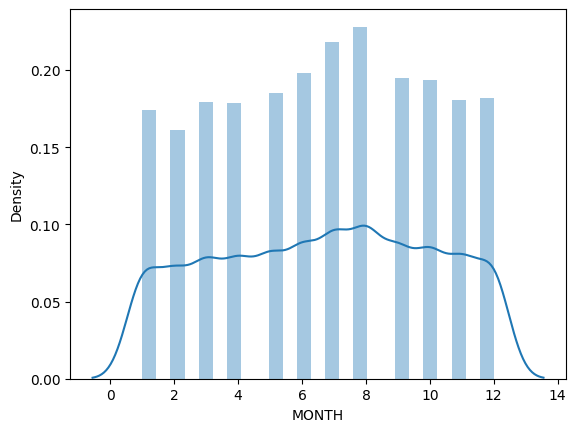

In [100]:
sns.distplot(fdata.MONTH)

<Axes: xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

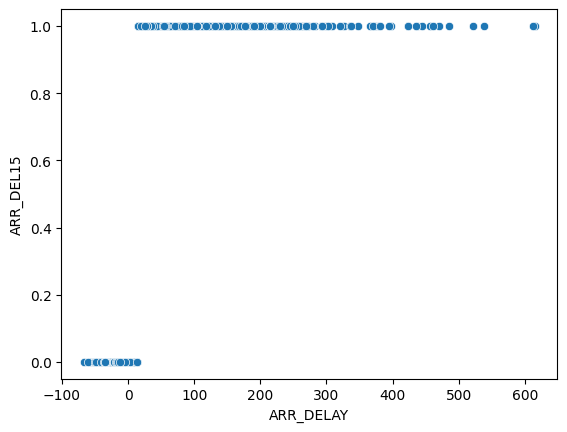

In [25]:
sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=fdata)

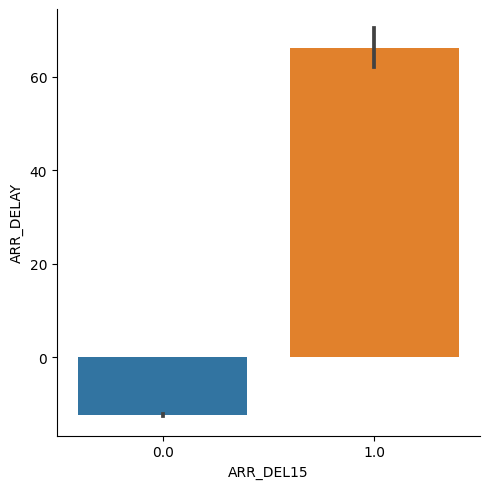

In [26]:
sns.catplot(x="ARR_DEL15",y="ARR_DELAY",kind='bar',data=fdata)

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FL_NUM        11231 non-null  int64  
 1   MONTH         11231 non-null  int64  
 2   DAY_OF_MONTH  11231 non-null  int64  
 3   DAY_OF_WEEK   11231 non-null  int64  
 4   CRS_ARR_TIME  11231 non-null  int64  
 5   DEP_DEL15     11231 non-null  float64
 6   ARR_DEL15     11231 non-null  float64
 7   ORIGIN_0      11231 non-null  uint8  
 8   ORIGIN_1      11231 non-null  uint8  
 9   ORIGIN_2      11231 non-null  uint8  
 10  ORIGIN_3      11231 non-null  uint8  
 11  ORIGIN_4      11231 non-null  uint8  
 12  DEST_0        11231 non-null  uint8  
 13  DEST_1        11231 non-null  uint8  
 14  DEST_2        11231 non-null  uint8  
 15  DEST_3        11231 non-null  uint8  
 16  DEST_4        11231 non-null  uint8  
dtypes: float64(2), int64(5), uint8(10)
memory usage: 724.0 KB


<Axes: >

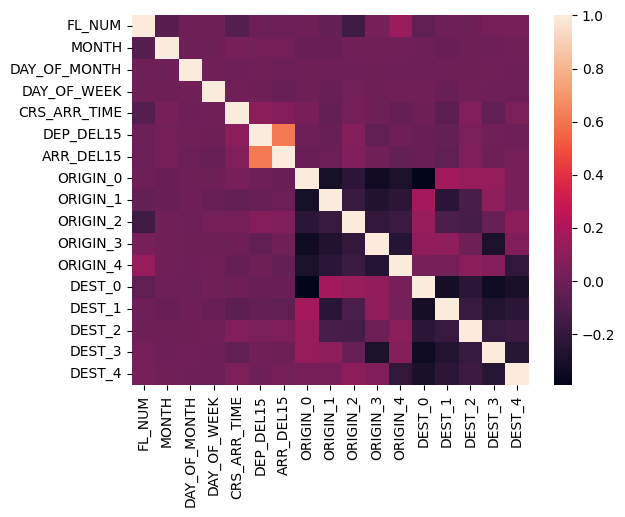

In [28]:
sns.heatmap(dataset.corr())

In [30]:
#x = dataset.iloc[:, 0:8].values
#y = dataset.iloc[:, 8:9].values


In [102]:
x.shape

(11231, 6)

In [104]:
x=np.concatenate((t,z,x),axis=1)

In [105]:
x.shape

(11231, 16)

In [139]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [107]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(dataset.drop('ARR_DEL15', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)

In [108]:
x_test.shape

(2247, 16)

In [109]:
x_train.shape

(8984, 16)

In [110]:
y_test.shape

(2247, 1)

In [111]:
y_train.shape

(8984, 1)

In [112]:
from pandas.io.stata import StataReader
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## **Model Building**

# **Decision tree model**

In [113]:
from sklearn.tree import DecisionTreeClassifier 
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [116]:
decisiontree = classifier.predict(x_test)

In [117]:
decisiontree

array([1., 0., 0., ..., 0., 0., 1.])

In [118]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [119]:
desacc

0.8673787271918113

In [121]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,decisiontree)
cm

array([[1777,  159],
       [ 139,  172]])

## **Random forest model**

In [122]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [123]:
rfc.fit(x_train,y_train)

<ipython-input-123-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [124]:
y_predict = rfc.predict(x_test)

## **ANN Model**

In [125]:
# Importing the Keras libraries and packagkes
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [126]:
# Creating ANN skleton view

classification = Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))

In [127]:
# Compiling the ANN model
classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [128]:

# Training the model
classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)

Epoch 1/100
1797/1797 [==============================] - 7s 3ms/step - loss: 0.2933 - accuracy: 0.8952 - val_loss: 0.2781 - val_accuracy: 0.9082
Epoch 2/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2712 - accuracy: 0.9052 - val_loss: 0.2798 - val_accuracy: 0.9071
Epoch 3/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.2668 - accuracy: 0.9061 - val_loss: 0.2742 - val_accuracy: 0.9082
Epoch 4/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2651 - accuracy: 0.9061 - val_loss: 0.2717 - val_accuracy: 0.9037
Epoch 5/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.2621 - accuracy: 0.9071 - val_loss: 0.2838 - val_accuracy: 0.8987
Epoch 6/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.2591 - accuracy: 0.9080 - val_loss: 0.2695 - val_accuracy: 0.9032
Epoch 7/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.2572 - accuracy: 0.9076 - val_loss: 0.2699 - val_ac

## **Test the Model**

In [129]:
## Decision tree

y_pred = classifier.predict([[129,99,1,0,0,1,0,1,1,1,0,1,1,1,1,1]])
print(y_pred)
y_pred

[0.]


array([0.])

In [130]:
## RandomForest

y_pred = rfc.predict([[129,99,1,0,0,1,0,1,1,1,0,1,1,1,1,1]])

print(y_pred)
(y_pred)

[0.]


array([0.])

In [131]:
classification.save('flight.h5')

In [132]:
# Testing the model

y_pred = classification.predict(x_test)

y_pred

71/71 [==============================] - 0s 1ms/step


array([[1.6844062e-04],
       [2.3044127e-18],
       [5.9257243e-03],
       ...,
       [1.4979976e-22],
       [3.3422094e-03],
       [1.0000000e+00]], dtype=float32)

In [133]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [136]:
def predict_exit(sample_value):
  # Convert list to numpy array
  sample_value = np.array(sample_value)
  # Reshape because sample_value contains only 1 record
  sample_value = sample_value.reshape(1, -1)
  # Feature Scaling
  sample_value = sc.transform(sample_value)
  return classifier.predict(sample_value)
  
test=classification.predict([[1,1,121.000000,36.0,0,0,1,0,1,1,1,1,1,1,1,1]])
if test==1:
  print('prediction: Chance of delay')
else:
  print('Prediction: No chance of delay.')

1/1 [==============================] - 0s 71ms/step
Prediction: No chance of delay.


## **Performance Testing & Hyperparameter Tuning**

In [138]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

In [145]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
cm

array([[1877,   59],
       [ 162,  149]])

In [146]:
# Accuracy score of desicionTree

from sklearn.metrics import accuracy_score
dasacc = accuracy_score(y_test,decisiontree)

In [147]:
desacc

0.8673787271918113

In [148]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,decisiontree)

In [149]:
cm

array([[1777,  159],
       [ 139,  172]])

In [150]:
# Calculate the Accuracy of ANN
from sklearn.metrics import accuracy_score,classification_report
score = accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is: {}%'.format(score*100))

The accuracy for ANN model is: 86.78237650200266%


In [153]:
# giving some parameters that can be used in randized search cv
parameters = {
              'n_estimators' : [1,20,30,55,68,74,90,120,115],
              'criterion':['gini','entropy'],
              'max_features' : ["auto", "sqrt", "log2"],
      'max_depth' : [2,5,8,10], 'verbose' :[1,2,3,4,6,8,9,10] 
      
}

In [155]:
#performing the randomized cv
RCV = RandomizedSearchCV(estimator=rfc,param_distributions=parameters,cv=10,n_iter=4)

In [156]:
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tre

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74
building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 11

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1

building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.9s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [157]:
#getting the best paarmets from the giving list and best score from them
bt_params = RCV.best_params_
bt_score = RCV.best_score_
        

In [158]:
bt_params

{'verbose': 2,
 'n_estimators': 115,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [159]:
bt_score

0.905498809615237

In [160]:
model = RandomForestClassifier(verbose= 10, n_estimators= 120, max_features= 'log2',max_depth= 10,criterion= 'entropy')
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:  

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tre

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select


building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tre

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elap

building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elaps

building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
buildi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 o

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elaps

building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tr

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s fi

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_

building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=

building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [161]:
y_predict_rf = RCV.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [162]:
RFC=accuracy_score(y_test,y_predict_rf)
RFC

0.9074321317311972

In [164]:
import sklearn.metrics as metrics
fpr1,tpr1,threshold1=metrics.roc_curve(y_test,decisiontree)
roc_acu1=metrics.auc(fpr1,tpr1)

In [165]:
fpr1

array([0.       , 0.0821281, 1.       ])

In [166]:
tpr1

array([0.        , 0.55305466, 1.        ])

In [167]:
threshold1

array([2., 1., 0.])

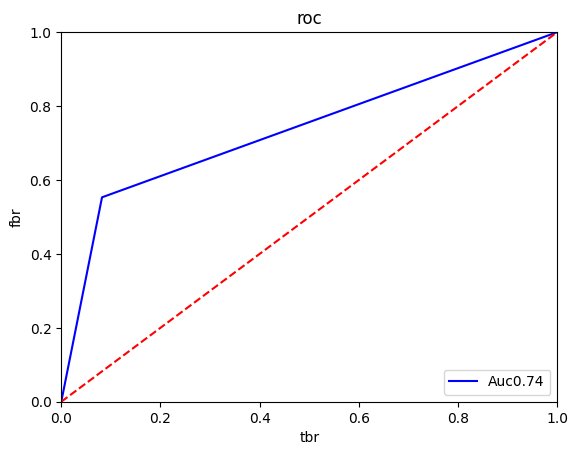

In [169]:
import matplotlib.pyplot as plt
plt.title("roc")
plt.plot(fpr1,tpr1,'b', label="Auc%0.2f"%roc_acu1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("tbr")
plt.ylabel("fbr")
plt.show()


In [170]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))